In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
from scipy.signal import periodogram

# Load timeseries data

In [2]:
# load water data
water_data = pd.read_csv("water_consumption_data/water.csv")

# Set date as index
water_data["Datetime"] = pd.to_datetime(water_data["Datetime"])
water_data = water_data.set_index("Datetime")

water_data

,Consumption
Datetime,
2002-01-01 01:00:00,30393
2002-01-01 02:00:00,29265
2002-01-01 03:00:00,28357
2002-01-01 04:00:00,27899
2002-01-01 05:00:00,28057
...,...
2016-12-31 19:00:00,34478
2016-12-31 20:00:00,33328
2016-12-31 21:00:00,32197


In [3]:
# Check for missing and duplicate values
print(f"missing date values: {water_data.index.isnull().any() == True}")
print(f"missing water consumption values: {water_data['Consumption'].isnull().any() == True}")
print(f"Duplicate date values: {water_data.index.has_duplicates}" )

missing date values: False
missing water consumption values: False
Duplicate date values: True


In [4]:
# Show duplicate values
water_data[water_data.index.duplicated()]

,Consumption
Datetime,
2014-11-02 02:00:00,23755
2015-11-01 02:00:00,21171
2016-11-06 02:00:00,21692


In [5]:
# Remove duplicates (keep the first occurencies)
water_data = water_data[~water_data.index.duplicated()]
water_data

,Consumption
Datetime,
2002-01-01 01:00:00,30393
2002-01-01 02:00:00,29265
2002-01-01 03:00:00,28357
2002-01-01 04:00:00,27899
2002-01-01 05:00:00,28057
...,...
2016-12-31 19:00:00,34478
2016-12-31 20:00:00,33328
2016-12-31 21:00:00,32197


In [6]:
# Sort by date in case order changed
water_data = water_data.sort_index()

# Plot timeseries

We plot the timeseries on hourly, daily, and weekly frequency. The last two aggreagate the values of every 24 and 168 hours respectively

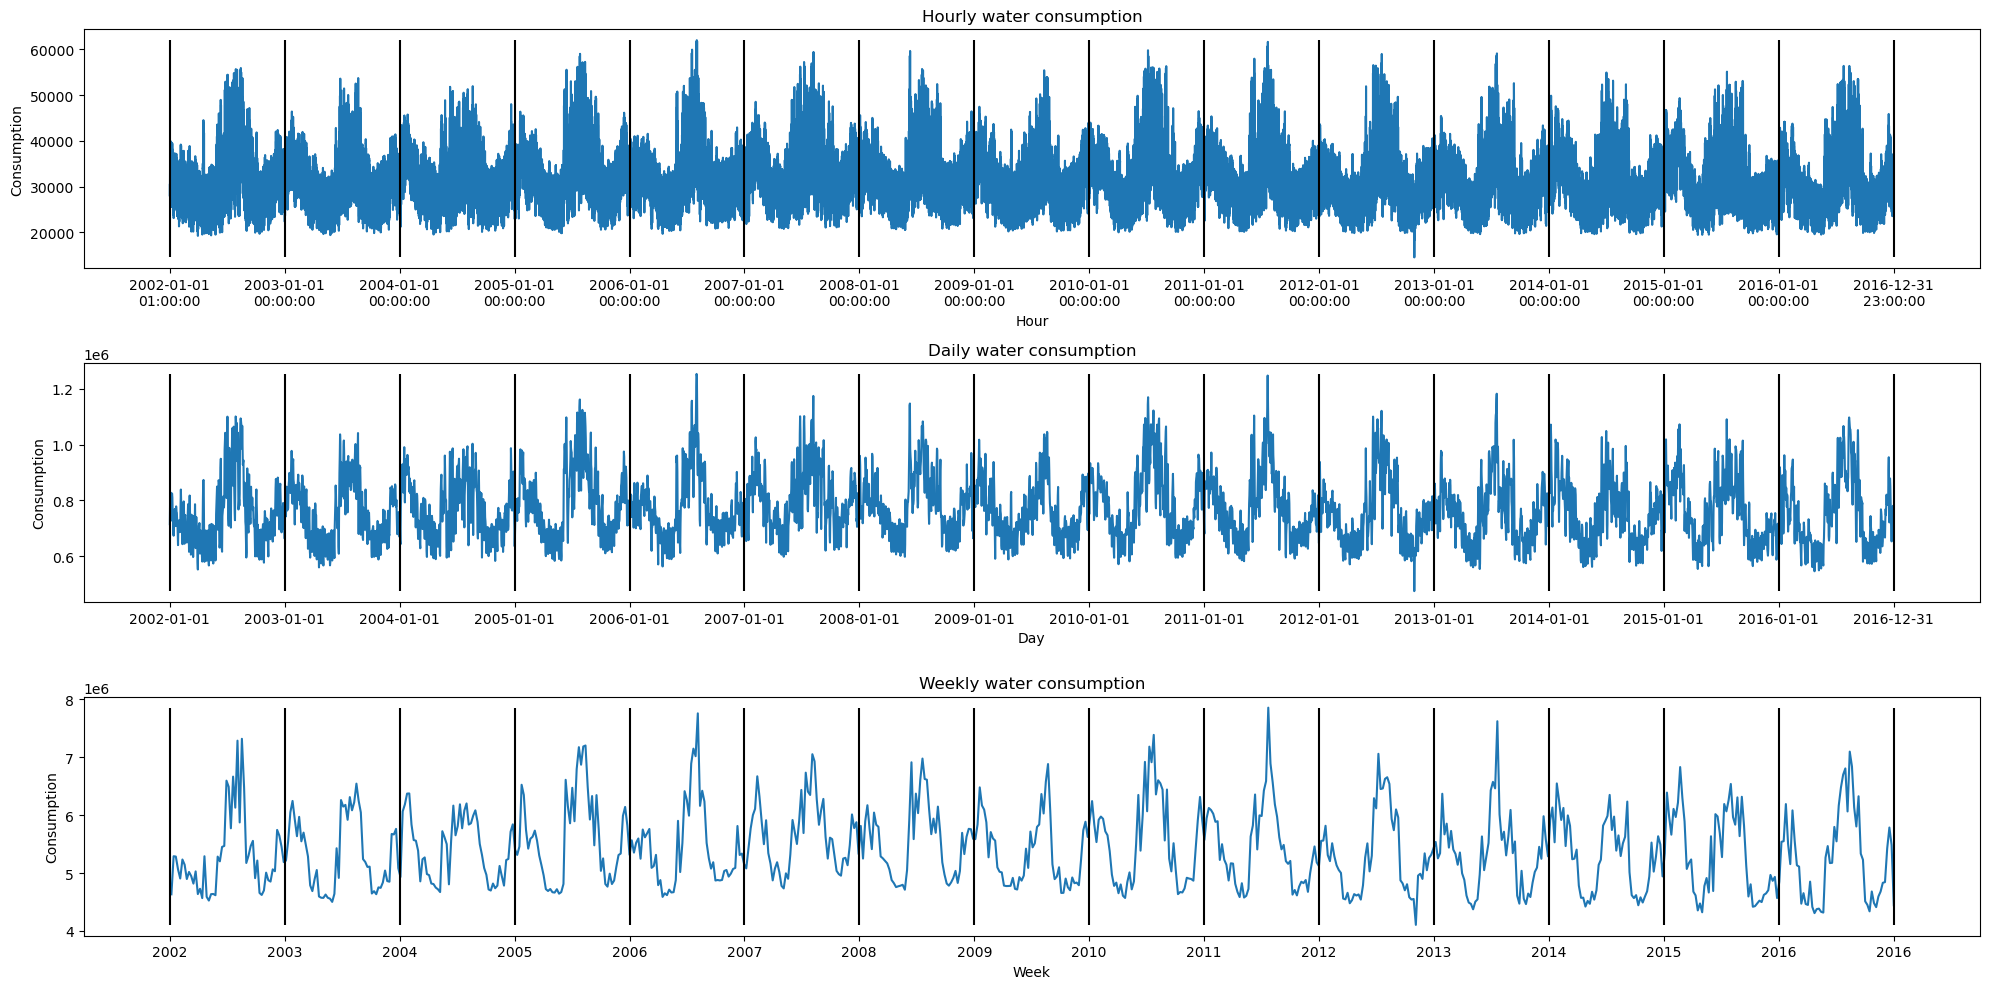

In [66]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

# HOURLY

# Get the dates
dates = water_data.index

# Plot only the first labels of each year
xticks1 = [dates[0]] + dates[(dates.hour == 0) & (dates.day == 1) & (dates.month == 1)].tolist() + [dates[-1]]

axes[0].plot(water_data)
axes[0].set_xlabel("Hour")
axes[0].set_xticks(xticks1, [str(tick).split(" ")[0] + "\n"+str(tick).split(" ")[1] for tick in xticks1])

# Add vertical lines to each year
axes[0].vlines(xticks1, ymin=water_data.min(), ymax=water_data.max(), colors=["black" for _ in range(len(xticks1))])

axes[0].set_ylabel("Consumption")
axes[0].set_title("Hourly water consumption")

# DAILY

daily_water_data = water_data.resample('D').sum()

axes[1].plot(daily_water_data)
axes[1].set_xlabel("Day")
axes[1].set_xticks(xticks1)

# Add vertical lines to each year
axes[1].vlines(xticks1, ymin=daily_water_data.min(), ymax=daily_water_data.max(), colors=["black" for _ in range(len(xticks1))])

axes[1].set_ylabel("Consumption")
axes[1].set_title("Daily water consumption")

# WEEKLY

weekly_water_data = water_data.resample('W').sum()

axes[2].plot(weekly_water_data)
axes[2].set_xlabel("Week")
axes[2].set_xticks(xticks1, [str(tick).split("-")[0] for tick in xticks1])

# Add vertical lines to each year
axes[2].vlines(xticks1, ymin=weekly_water_data.min(), ymax=weekly_water_data.max(), colors=["black" for _ in range(len(xticks1))])

axes[2].set_ylabel("Consumption")
axes[2].set_title("Weekly water consumption")

plt.tight_layout()
plt.show()

# Analize timeseries

## First plots

From a first point of view, we can suppose that the timeseries is stationary with a yearly seasonality component. Lets take a look closer, in an interval of one year, month and week:

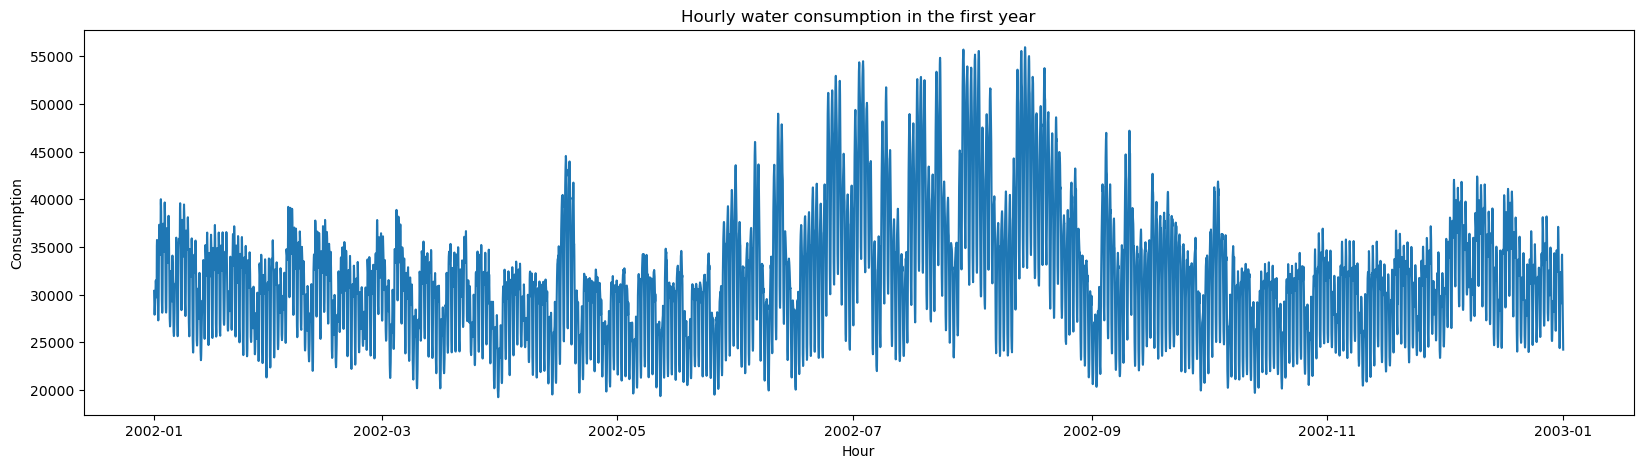

In [67]:
plt.figure(figsize=(20,5))
plt.plot(water_data.head(24*365))
plt.xlabel("Hour")
plt.ylabel("Consumption")
plt.title("Hourly water consumption in the first year")
plt.show()

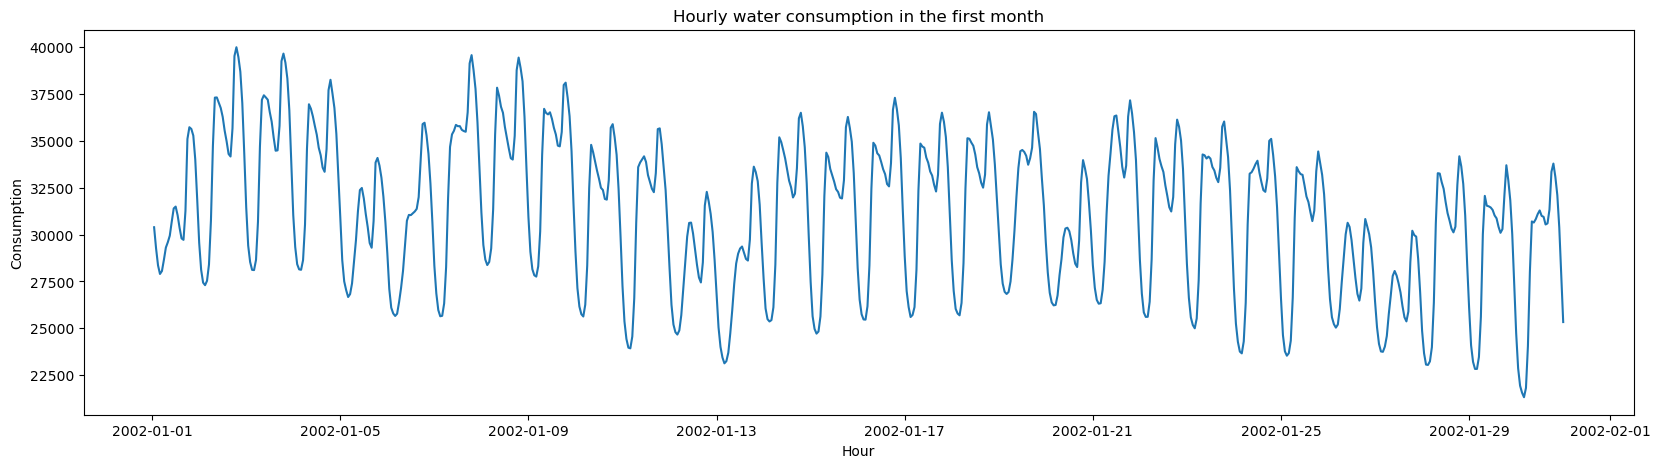

In [68]:
plt.figure(figsize=(20,5))
plt.plot(water_data.head(24*30))
plt.xlabel("Hour")
plt.ylabel("Consumption")
plt.title("Hourly water consumption in the first month")
plt.show()

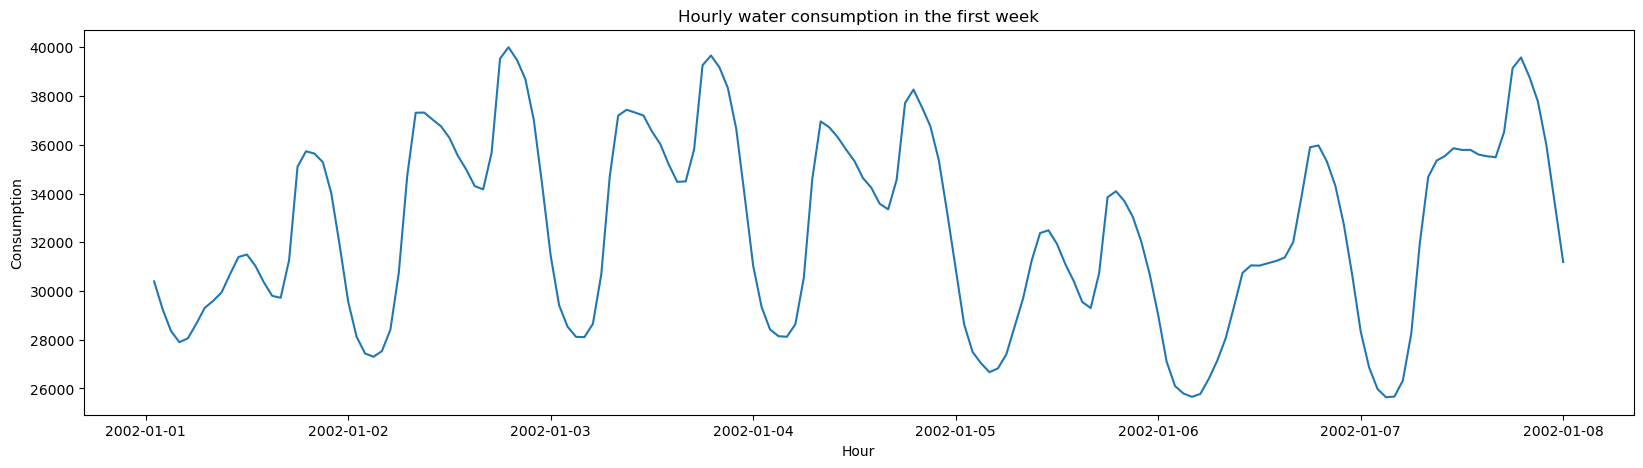

In [70]:
plt.figure(figsize=(20,5))
plt.plot(water_data.head(24*7))
plt.xlabel("Hour")
plt.ylabel("Consumption")
plt.title("Hourly water consumption in the first week")
plt.show()

It seems that it is likely for the timeseries to have a weekly and daily seasonality as well.

## Stationarity test

Lets first test for the **stationarity** of the timeseries. We use a statistical test which is called **Augmented Dickey-Fuller Test**. It uses the following **null** and **alternative** hypothesis:

H0: The time series is non-stationary.<br>
HA: The time series is stationary.

In [71]:
from statsmodels.tsa.stattools import adfuller

# Perform augmented Dickey-Fuller test
adfuller(water_data["Consumption"])

(-17.998137982355626,
 2.7400016428095596e-30,
 73,
 131393,
 {'1%': -3.43039976998591,
  '5%': -2.861561997611945,
  '10%': -2.566781708548999},
 1894827.9045179007)

The **p-value** is approximately **2.74*10^(-30)**, which means it is less than any common used significance level (for example 0.05). We conclude that we can reject the null hypothesis and consider our timeseries stationary

## Seasonality test

Lets make a periodogram to observe any periodicity (seasonality) in the timeseries

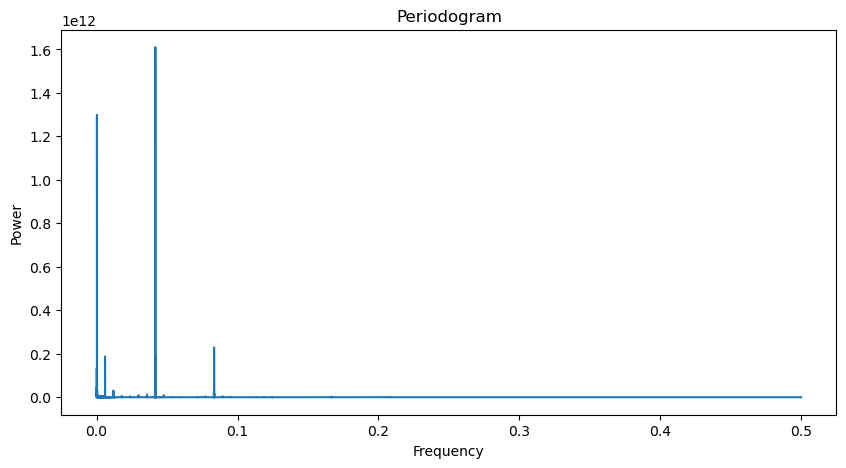

In [72]:
# Calculate the periodogram
frequencies, power = periodogram(water_data["Consumption"], fs=1)

plt.figure(figsize=(10,5))
plt.plot(frequencies, power)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Periodogram")
plt.show()

We can clearly see that there are some strong frequencies embeded in the series. Now lets convert them to periods to see what is actualy happening. We take the 5 most strong frequencies and convert them to periods, then we round them up:

In [73]:
top5_index = np.argsort(power)[-5:][::-1]
print(f"Top 5 periods: {(1/frequencies[top5_index]).round()}", f"Top 5 powers {power[top5_index]}", sep="\n")

Top 5 periods: [  24. 4382.   12.  168.   24.]
Top 5 powers [1.61001552e+12 1.29868918e+12 2.29150833e+11 1.87523906e+11
 1.87368996e+11]


After we round up the values of the periods, we get the following results: 
1. The most strong periodic component has period = 24 (Daily seasonality) 
2. The second strongest periodic component has period = 4382 (almost half year seasonality, half year has 4380 hours) 
3. The third strongest periodic component has period = 168 (Weekly seasonality, 1 week has 168 hours)
4. The fourth strongest periodic component has again period = 24 (possibly the 24 period has a compound periodicity)
5. The fifth strongest periodic component has period = 12 (half day seasonality)

# Forecasting

We will use neural prophet model as a forecasting tool. It is made in pytorch and implements machine learning algorithms to estimate the parameters (SGD or AdamW optimizers) during training. 

In [7]:
prophet_data = water_data.reset_index()
prophet_data = prophet_data.rename(columns = {"Datetime": "ds", "Consumption": "y"})
prophet_data

,ds,y
0,2002-01-01 01:00:00,30393
1,2002-01-01 02:00:00,29265
2,2002-01-01 03:00:00,28357
3,2002-01-01 04:00:00,27899
4,2002-01-01 05:00:00,28057
...,...,...
131462,2016-12-31 19:00:00,34478
131463,2016-12-31 20:00:00,33328
131464,2016-12-31 21:00:00,32197
131465,2016-12-31 22:00:00,30909


## Model 1

We begin by splitting to train and test sets. We choose train period to be 2002-2014 and validation period 2015-2016. <br>
The first model we will try to fit is a Piecewise linear trend (10 changepoints on the 80% of train set) combined with daily, weekly and yearly seasonalities<br>
After we fit the model, we observe the last epoch metrics, the prediction on test and validation sets and the fited components

In [ ]:
from neuralprophet import NeuralProphet

# defaults:
# Piecewise linear trend. 10 changepoints on the 80% of train set
# Daily, weekly and yearly seasonality
m = NeuralProphet()

# split to train period = 2002-2014 (13 years) and test period = 2015-2016 (2 years)
df_train, df_test = m.split_df(prophet_data, freq="H", valid_p= (2*24*365 + 22)/len(prophet_data))


WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm

WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\df_utils.py:864: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.978% of the data.
WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\df_utils.py:885: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_ran

In [9]:
df_train

,ds,y
0,2002-01-01 01:00:00,30393
1,2002-01-01 02:00:00,29265
2,2002-01-01 03:00:00,28357
3,2002-01-01 04:00:00,27899
4,2002-01-01 05:00:00,28057
...,...,...
113920,2014-12-31 19:00:00,38906
113921,2014-12-31 20:00:00,37772
113922,2014-12-31 21:00:00,36602
113923,2014-12-31 22:00:00,35326


In [10]:
df_test

,ds,y
0,2015-01-01 00:00:00,32802
1,2015-01-01 01:00:00,31647
2,2015-01-01 02:00:00,30755
3,2015-01-01 03:00:00,30189
4,2015-01-01 04:00:00,29890
...,...,...
17537,2016-12-31 19:00:00,34478
17538,2016-12-31 20:00:00,33328
17539,2016-12-31 21:00:00,32197
17540,2016-12-31 22:00:00,30909


In [ ]:
# Fit model and get epoch info
metrics = m.fit(df_train, freq="H", validation_df=df_test, progress="bar")

In [39]:
# Export metrics to csv
metrics.to_csv("first_model_metrics.csv")
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
55,0.007162,2674.49087,3559.555155,0.0,0.009241,3057.879283,3852.822808


WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\df_utils.py:864: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\df_utils.py:885: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))



WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\df_utils.py:864: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\df_utils.py:864: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\df_utils.py:864: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col).view(dtype=np.int64)

WARNING - (py.wa

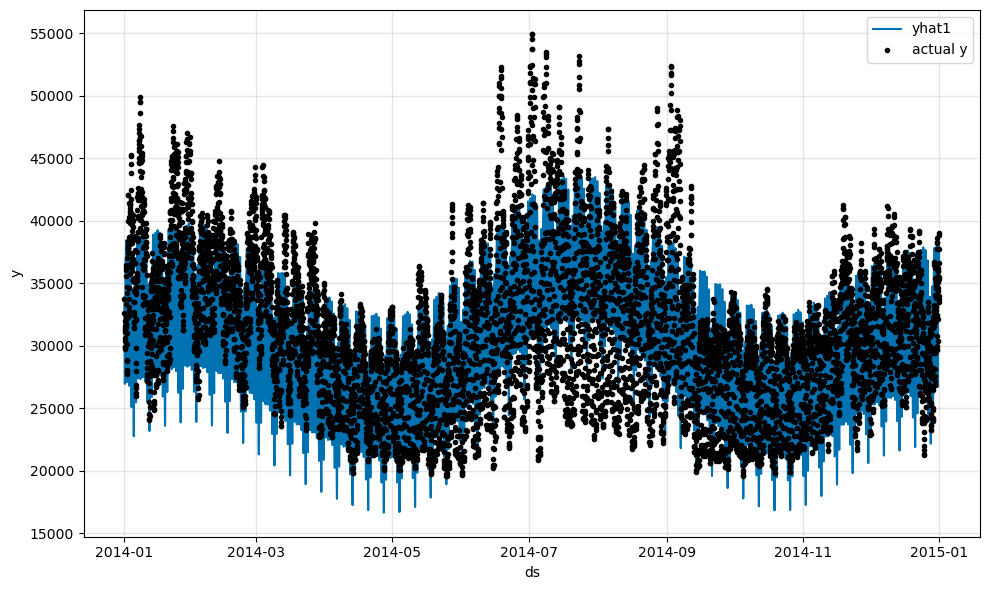

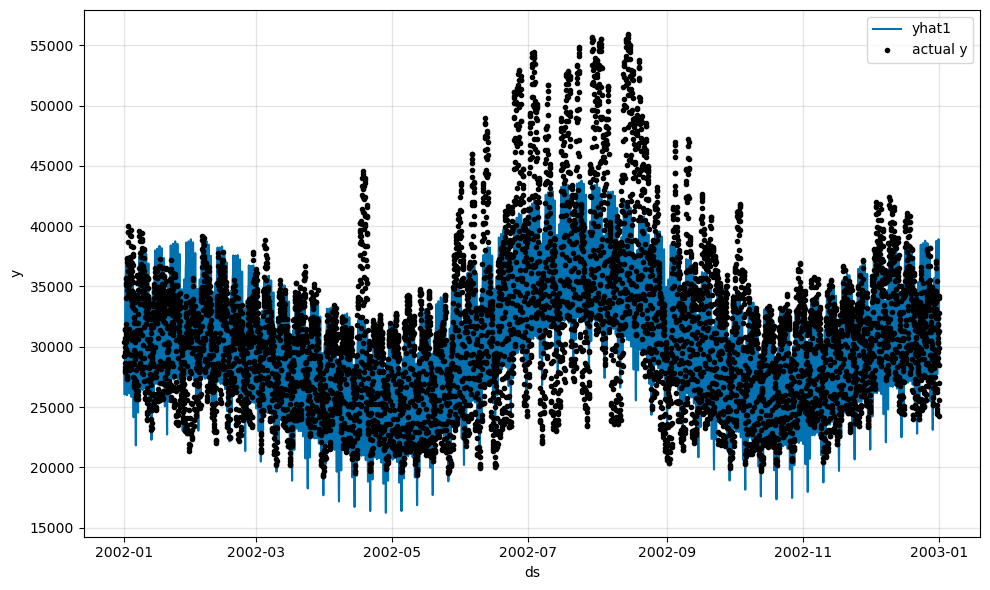

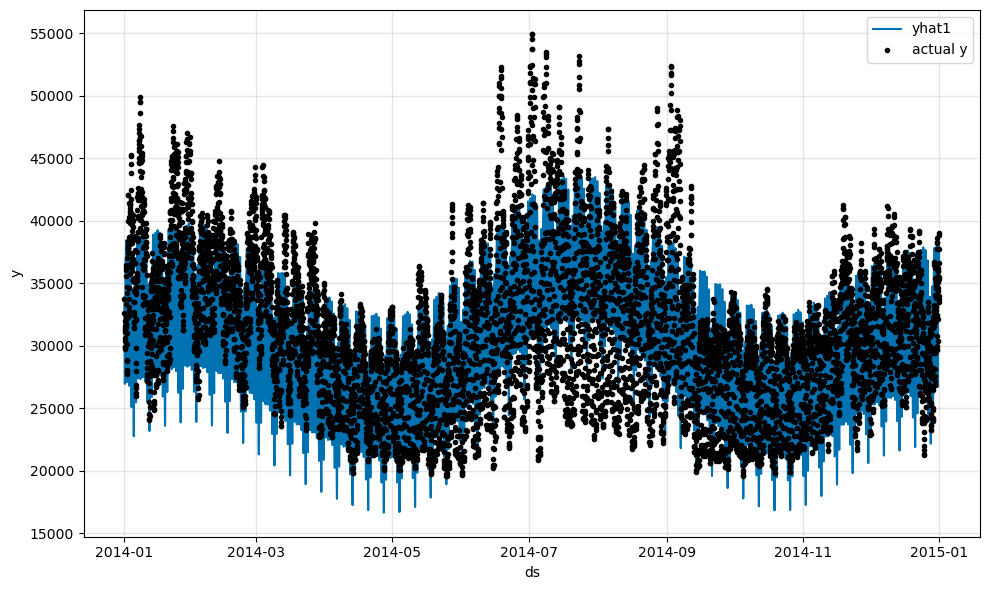

In [38]:
# Make the prediction and plot the first and last years of train set
forecast = m.predict(df_train)
m.plot(forecast[:24*365])
m.plot(forecast[-24*365:])

WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\df_utils.py:864: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col).view(dtype=np.int64)



WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\df_utils.py:885: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\df_utils.py:864: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\df_utils.py:864: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col).view(dtype=np.int64)

WARNING - (py.warnings._showwarnms

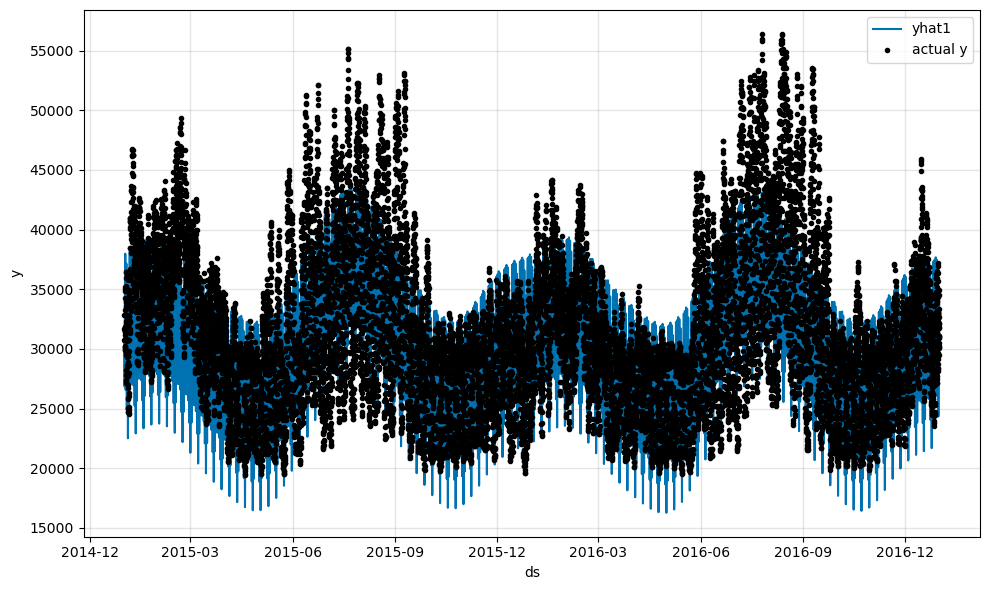

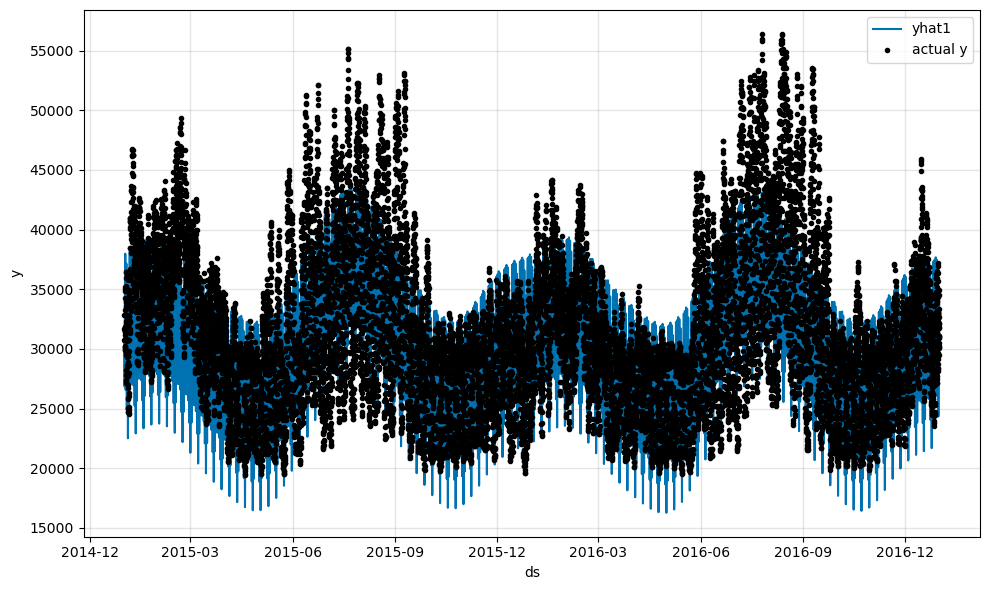

In [ ]:
# Plot the prediction on validation set
val_forecast = m.predict(df_test)
m.plot(val_forecast)

WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\plot_model_parameters.py:359: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  days = pd.date_range(start=t_start, end=t_end, freq=m.data_freq)

WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\plot_model_parameters.py:362: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y["ds"].dt.to_pydatetime(), df_trend["trend"], ls="-", c="#0072B2")

WARNING - (py.warnings._showwarnmsg) - c:\Users\nikos\anaconda3\envs\konnektable\lib\site-packages\neuralprophet\plot_model_parameters.py:607: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is depr

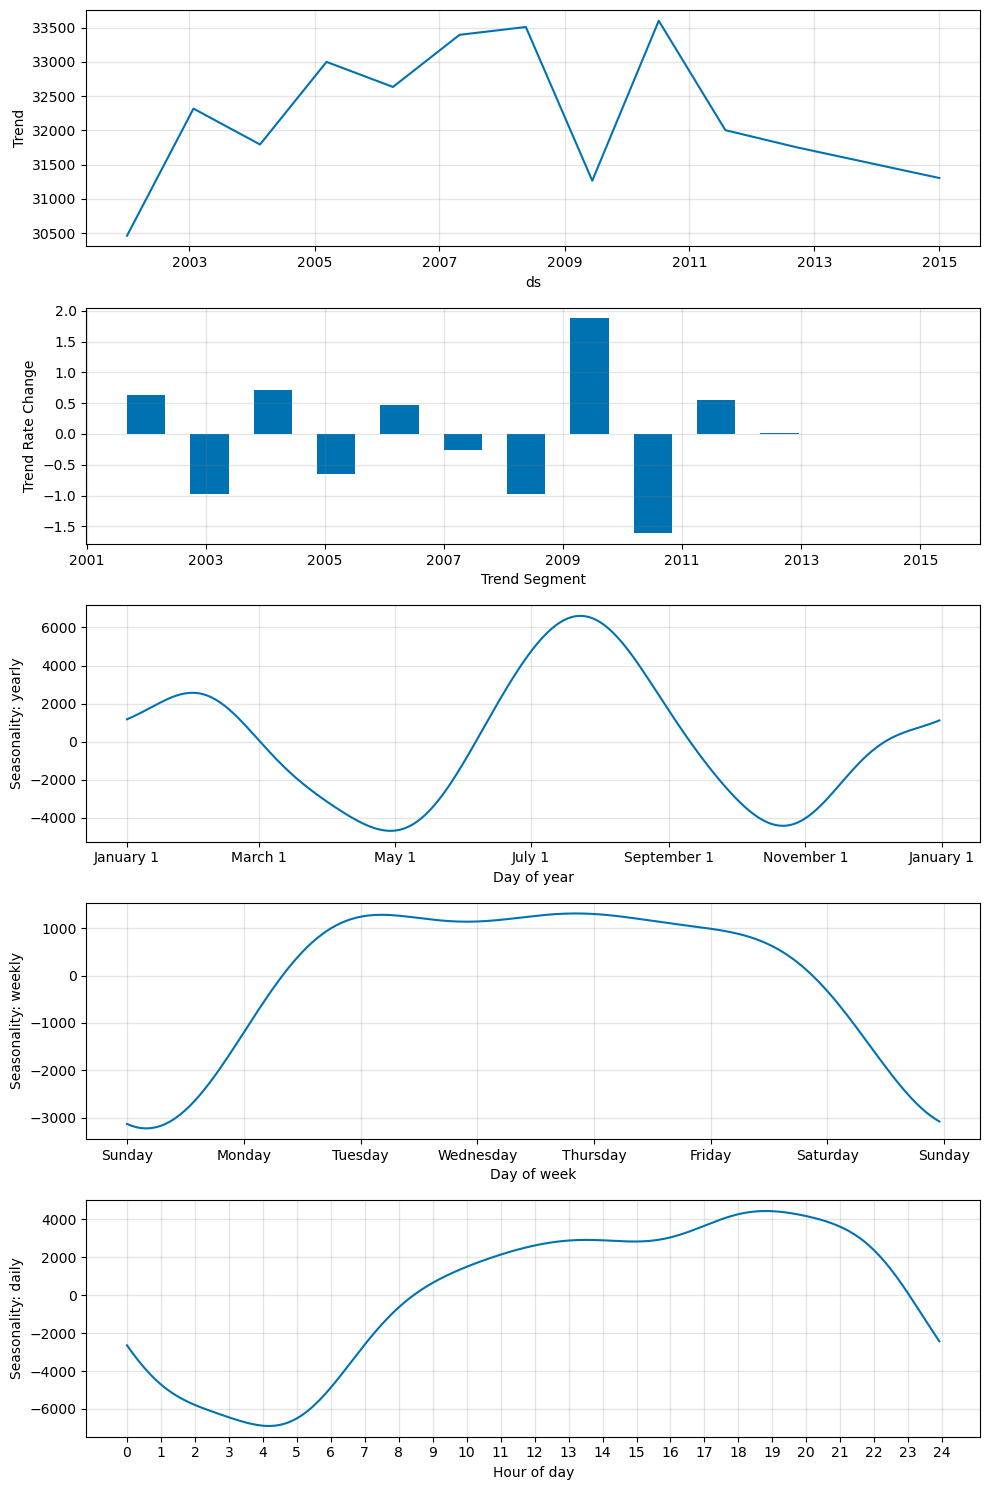

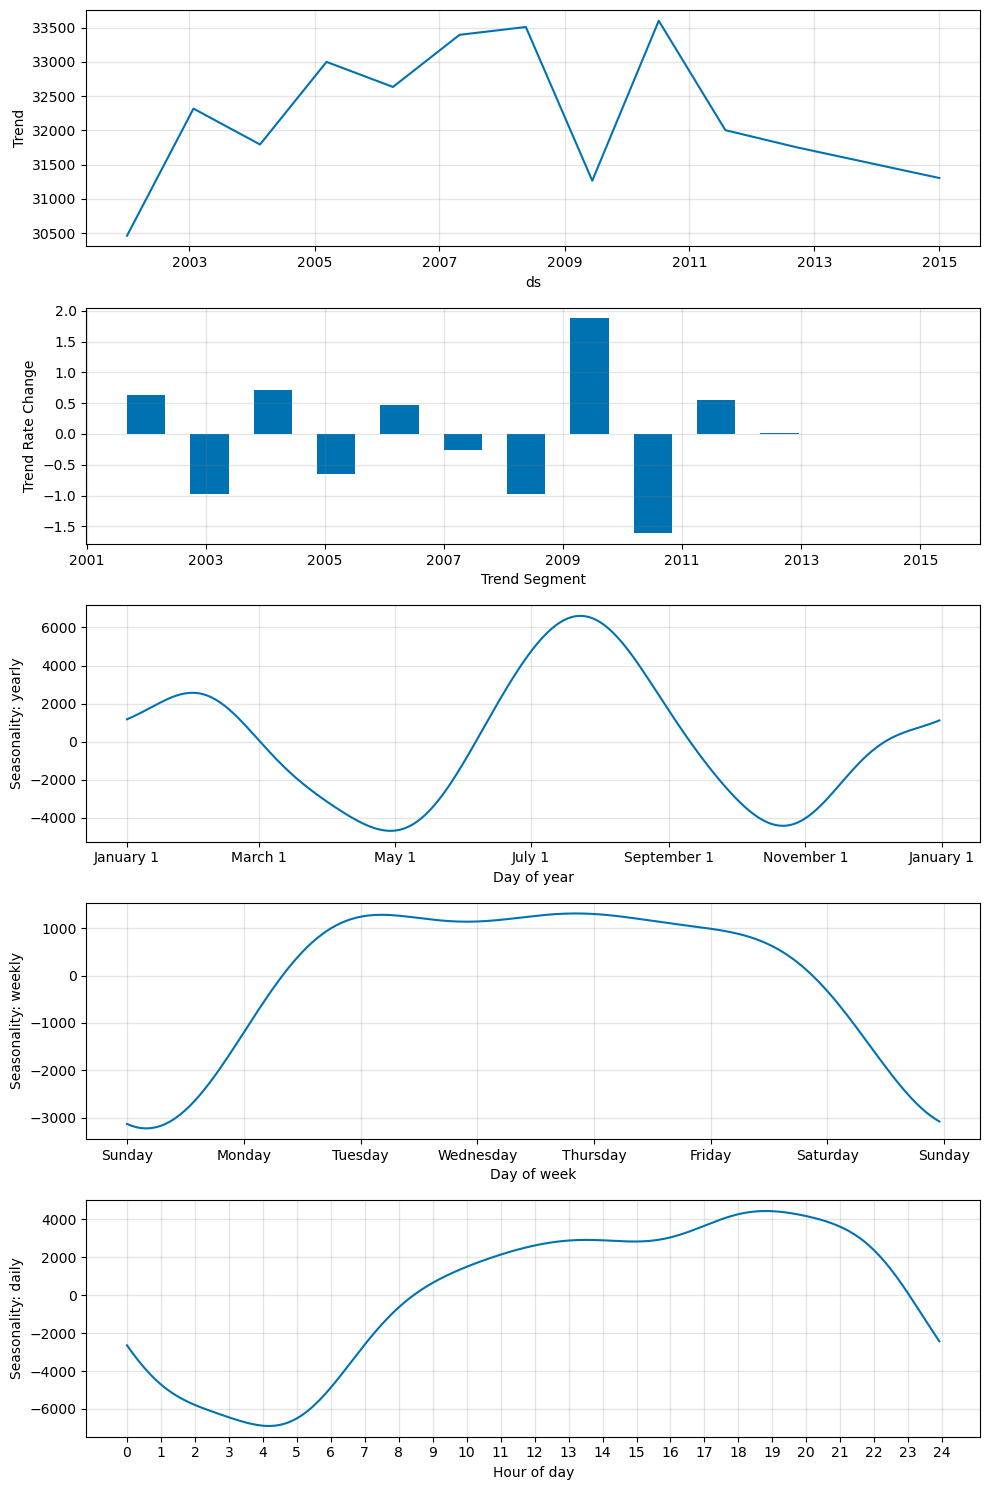

In [ ]:
# Plot the fitted components
m.plot_parameters()